In [1]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload
import matplotlib.pyplot as plt


import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

wavelength = 633e-9
fl = 500e-3
fsm_pupil_diam = 6.8e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(1/pxscl_lamD)



/opt/conda/envs/km310gpu/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


19.200826816825295 arcsec
13.491048593350387


In [6]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [3]:
npsf = 100
cam.set_roi(530, 900, npsf, client0)

In [4]:
cam.set_exptime(0.0001, client0)

INFO:utils:Got semaphore index 1.


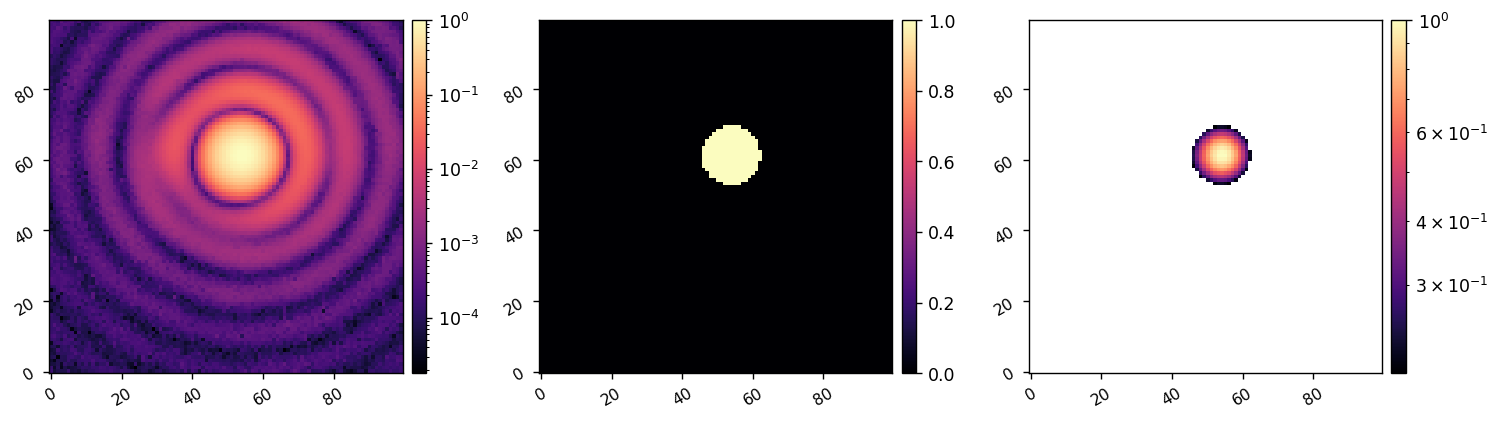

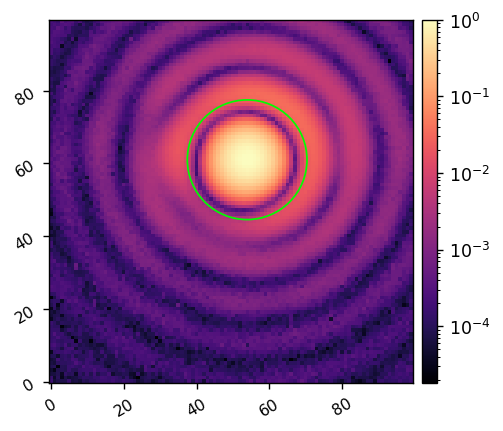

In [7]:
cam.Nframes = 1000
im_bias = cam.snap()

reload(utils)
cen = utils.centroid(im_bias, thresh=0.2, plot=True)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


# Record a short time series at the sampling of the camera's framerate

In [24]:
t_total = 5*u.s
exp_time = client0[f'campupil.exptime.current']
fps = client0[f'campupil.fps.current']
hdr = {
    'EXPTIME':exp_time,
    'FPS':fps, 
    'T_TOTAL':t_total.to_value(u.s),
}

In [25]:
cam.Nframes = t_total.to_value(u.s)*fps
print(cam.Nframes)

frames = cam.snap_cube()

utils.save_fits(f'data/drift/{today}_short_drift_data_fsm_off.fits', frames, header=hdr, ow=True)


6226.64978027345
Saved data to:  data/drift/20241016_short_drift_data_fsm_off.fits


# Record a long time series with large temporal sampling.

In [34]:

# t_total = 5*u.s
t_total = 30*u.min
freq = 5*u.Hz
Nexp_per_frame = 100

Nframes_total = t_total.to_value(u.s) * freq.to_value(u.Hz)
exp_time = client0[f'campupil.exptime.current']
fps = client0[f'campupil.fps.current']
print(Nframes_total, Nexp_per_frame)
print(1/freq.to_value(u.Hz), Nexp_per_frame/fps)
hdr = {
    'FREQ':freq.to_value(u.Hz),
    'EXPTIME':exp_time,
    'NEXPS':Nexp_per_frame, 
    'FPS':fps, 
    'T_TOTAL':t_total.to_value(u.s),
}
Nframes_total * 100**2 * 8 / 1e9

9000.0 100
0.2 0.08030000363663331


np.float64(0.72)

In [35]:

start = time.time()
end = start + t_total.to_value(u.s)
count = 0
frames = []
cam.Nframes = 10

print('Collecting data')
while time.time()<end:
    frames.append(cam.snap())
    count += 1
    time.sleep(1/freq.to_value(u.Hz))
frames = np.array(frames)

utils.save_fits(f'data/drift/{today}_long_drift_data_fsm_off.fits', frames, header=hdr, ow=True)


Saved data to:  data/drift/20241016_long_drift_data_fsm_off.fits


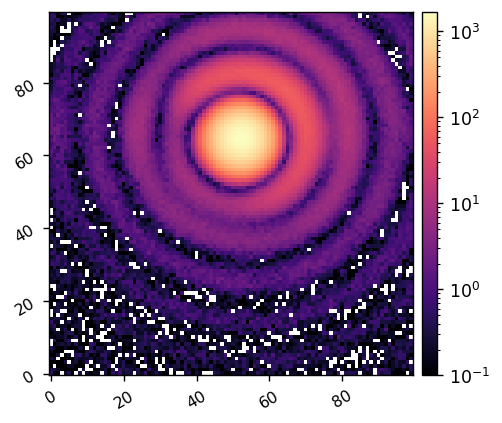

In [33]:
imshow1(frames[20], lognorm=True)